In [1]:
pip install tensorflow

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## Step 1: Defineing dataset path


In [2]:
DATASET_PATH = "D:\Downloads\CP2\CP2"  # Change this to your dataset folder
IMG_SIZE = (128, 128)  # Resize all images to 128x128
BATCH_SIZE = 32

In [3]:
# Fault type ranges
fault_ranges = {
    "Health": (1, 104),
    "Missing tooth": (105, 208),
    "Crack": (209, 312),
    "Spalling": (313, 416),
    "Chipping_tip_5": (417, 520),
    "Chipping_tip_4": (521, 624),
    "Chipping_tip_3": (625, 728),
    "Chipping_tip_2": (729, 832),
    "Chipping_tip_1": (833, 936),
}

## Step 2: Loading and preprocess images


In [4]:
def load_images_and_labels():
    images, labels = [], []
    
    for i in range(1, 937):  # Loop over all 936 images (1 to 936)
        img_path = os.path.join(DATASET_PATH, f"{i}.jpg") 
        
        # Load and preprocess image
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0  # Normalize
        images.append(img)

        # Assign labels based on number range
        if 1 <= i <= 104:
            labels.append(0)  # Health
        elif 105 <= i <= 208:
            labels.append(1)  # Missing tooth
        elif 209 <= i <= 312:
            labels.append(2)  # Crack
        elif 313 <= i <= 416:
            labels.append(3)  # Spalling
        elif 417 <= i <= 520:
            labels.append(4)  # Chipping_tip_5
        elif 521 <= i <= 624:
            labels.append(5)  # Chipping_tip_4
        elif 625 <= i <= 728:
            labels.append(6)  # Chipping_tip_3
        elif 729 <= i <= 832:
            labels.append(7)  # Chipping_tip_2
        elif 833 <= i <= 936:
            labels.append(8)  # Chipping_tip_1

    return np.array(images), np.array(labels)



In [5]:
# Load dataset
X, y = load_images_and_labels()
y = to_categorical(y, num_classes=9)  # Convert labels to one-hot encoding

In [6]:
print(y.shape)  

(936, 9)


In [7]:
# Split data (80% train, 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (748, 128, 128, 3), Validation: (94, 128, 128, 3), Test: (94, 128, 128, 3)


### Step 3: Defineing CNN model


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 output classes
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Step 4: Train the model


In [12]:
epochs = 20
history = model.fit(
    X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=BATCH_SIZE
)

Epoch 1/20
24/24 [==============================] - 13s 378ms/step - loss: 3.1115 - accuracy: 0.5655 - val_loss: 6.4578 - val_accuracy: 0.1277
Epoch 2/20
24/24 [==============================] - 8s 318ms/step - loss: 0.4759 - accuracy: 0.8182 - val_loss: 21.2969 - val_accuracy: 0.1277
Epoch 3/20
24/24 [==============================] - 8s 322ms/step - loss: 0.3358 - accuracy: 0.8730 - val_loss: 28.2919 - val_accuracy: 0.1277
Epoch 4/20
24/24 [==============================] - 8s 317ms/step - loss: 0.2150 - accuracy: 0.9225 - val_loss: 33.9614 - val_accuracy: 0.1277
Epoch 5/20
24/24 [==============================] - 8s 320ms/step - loss: 0.1776 - accuracy: 0.9412 - val_loss: 35.4517 - val_accuracy: 0.1277
Epoch 6/20
24/24 [==============================] - 8s 343ms/step - loss: 0.2077 - accuracy: 0.9238 - val_loss: 39.8533 - val_accuracy: 0.1277
Epoch 7/20
24/24 [==============================] - 8s 320ms/step - loss: 0.1961 - accuracy: 0.9305 - val_loss: 38.4308 - val_accuracy: 0.1277

##  So lets  add EarlyStopping so the model automatically stop when validation loss stops improving.

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_val, y_val), callbacks=[early_stop])

Epoch 1/50
24/24 [==============================] - 8s 343ms/step - loss: 0.0849 - accuracy: 0.9666 - val_loss: 0.1778 - val_accuracy: 0.9362
Epoch 2/50
24/24 [==============================] - 8s 329ms/step - loss: 0.0967 - accuracy: 0.9612 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 3/50
24/24 [==============================] - 8s 341ms/step - loss: 0.0608 - accuracy: 0.9719 - val_loss: 5.7402e-04 - val_accuracy: 1.0000
Epoch 4/50
24/24 [==============================] - 8s 333ms/step - loss: 0.0522 - accuracy: 0.9759 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/50
24/24 [==============================] - 9s 380ms/step - loss: 0.0578 - accuracy: 0.9773 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/50
24/24 [==============================] - 9s 370ms/step - loss: 0.0628 - accuracy: 0.9706 - val_loss: 5.2466e-04 - val_accuracy: 1.0000
Epoch 7/50
24/24 [==============================] - 10s 420ms/step - loss: 0.0523 - accuracy: 0.9759 - val_loss: 0.0067 - val_accuracy: 1.00

### Step 5: Evaluate model


In [16]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

3/3 [==============================] - 0s 71ms/step - loss: 3.8046e-09 - accuracy: 1.0000
Test Accuracy: 100.00%


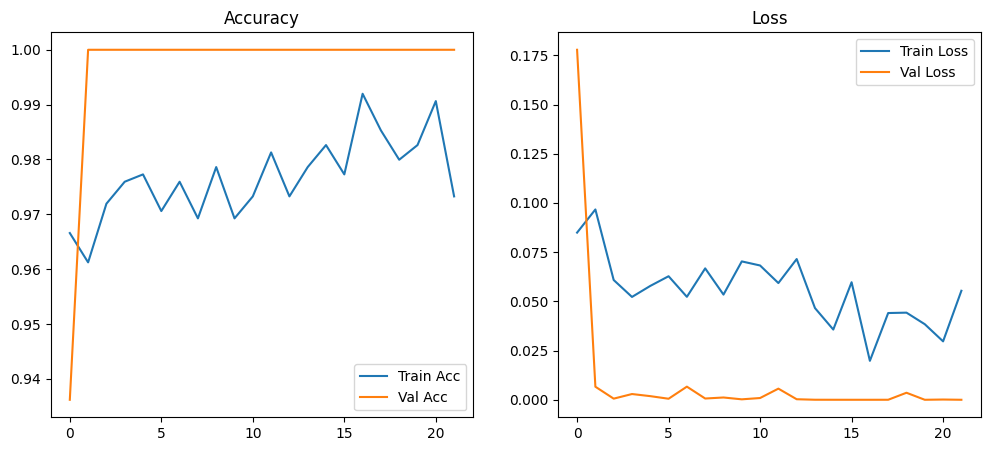

In [17]:
# Plot accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [18]:
# Save model
model.save("gear_defect_cnn.keras")

## Now Lets check if our model is running perfectly or not

In [19]:
!pip install opencv-python


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [21]:
# Load and preprocess a test image
def preprocess_image(img_path, target_size=(224, 224)):  
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0  
    return img_array
    


In [22]:
# Path to your test image
test_img_path = r"C:\Users\Prajwal S\Downloads\Sample gear\4.jpg" # Change this to your selected test image

# Load and display the image
test_img = preprocess_image(test_img_path)

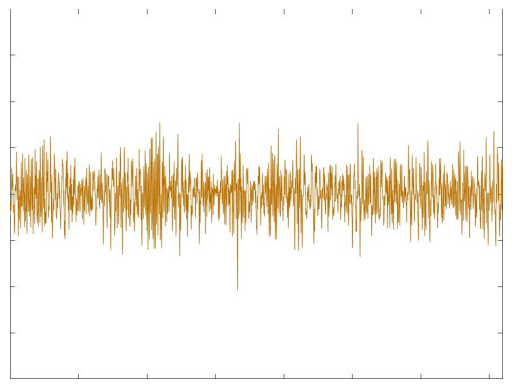

In [23]:
plt.imshow(cv2.imread(test_img_path))  # Show the image
plt.axis("off")
plt.show()

# Lets Test our Model

In [24]:
from tensorflow.keras.models import load_model


In [25]:
# Load the trained model
model = load_model("gear_defect_cnn.keras") 

In [26]:
class_labels = {
    1: "Healthy",
    2: "Missing Tooth",
    3: "Crack",
    4: "Spalling",
    5: "Chipping (Least Severe)",
    6: "Chipping (Moderate 1)",
    7: "Chipping (Moderate 2)",
    8: "Chipping (Moderate 3)",
    9: "Chipping (Most Severe)"
}

In [52]:
folder_path = r"C:\Users\Prajwal S\Downloads\Sample gear\309.jpg"
test_img = cv2.imread(folder_path)
test_img = cv2.resize(test_img, (128, 128))
test_img = test_img / 255.0
test_img = np.expand_dims(test_img, axis=0)

In [53]:
prediction = model.predict(test_img)


1/1 [==============================] - 0s 27ms/step


In [54]:
predicted_class = np.argmax(prediction)+1
print(f"Predicted Defect Type: {predicted_class} ({class_labels.get(predicted_class, 'Unknown')})")

Predicted Defect Type: 2 (Missing Tooth)


In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [58]:
y_pred = model.predict(X_test)  # Get predictions (probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels


3/3 [==============================] - 0s 100ms/step


In [59]:
cm = confusion_matrix(y_true_classes, y_pred_classes)


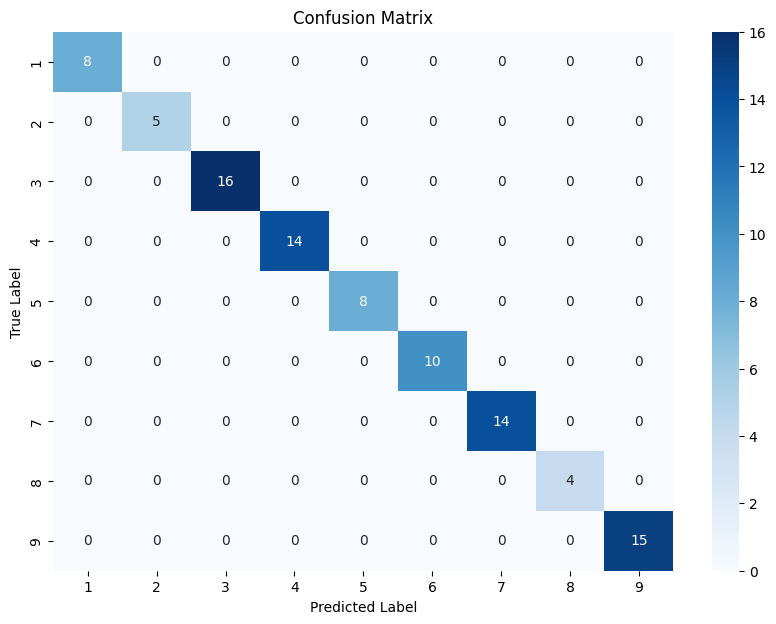

In [60]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


### Our model performs well, with most predictions on the diagonal (high accuracy).
### No significant misclassifications (off-diagonal values are zero).
### Fault types 3, 4, 7, and 9 have the highest correctly classified counts (16, 14, 14, and 15).
### Fault type 8 (Chipping Tip 2) has some difficulty, with only 4 correct classifications. 